In [2]:
import scipy.io as io
import numpy as np
import pandas as pd
import seaborn as sns
import timeit
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [3]:
def pca_run(X, y, fig = True):
    '''
    pca_run performs PCA on the dataset (X) and minimizes it to 2 components. It can also plot the two components based on their labels.
    
    Inputs:
        X: feature set
        y: classification
        fig: plots if true
    '''
    #initialize count and lists to classify samples by index
    count = 0
    norm = []
    anom = []
    
    #add indices to list by classification
    for i in y:
        if i == 0:
            norm.append(count)
        else:
            anom.append(count)
        count += 1
    
    #run PCA and store new components 
    pca = PCA(n_components=2)
    X_new = pca.fit_transform(X)
    
    #plot by classification
    if fig:
        plt.plot(X_new[norm, 0], X_new[norm, 1], 'bo', label = 'Normal')
        plt.plot(X_new[anom, 0], X_new[anom, 1], 'r*', label = 'Anomaly')
        plt.show()

In [4]:
def pca_mle(X, y, fig = True):
    '''
    pca_run performs PCA on the dataset (X) and minimizes it using MLE. It can also plot the first two components based on their labels.
    
    Inputs:
        X: feature set
        y: classification
        fig: plots if true
        
    Returns:
        X_new: PCA features
        y: classification (unchanged)
    '''
    #initialize count and lists to classify samples by index
    count = 0
    norm = []
    anom = []
    
    #add indices to list by classification
    for i in y:
        if i == 0:
            norm.append(count)
        else:
            anom.append(count)
        count += 1
    
    #run PCA and store new components
    pca = PCA(n_components='mle')
    X_new = pca.fit_transform(X)
    
    #plot by classification
    if fig:
        plt.plot(X_new[norm, 0], X_new[norm, 1], 'bo', label = 'Normal')
        plt.plot(X_new[anom, 0], X_new[anom, 1], 'r*', label = 'Anomaly')
        plt.show()

    return X_new, y

In [5]:
def cy(y):
    '''
    cy takes a list of 0s and 1s and changes them to 1s and -1s
    
    Inputs:
        y: original list
        
    Returns:
        newy: new list
    '''
    newy = y.copy()
    newy = newy.astype('int32')
    newy[np.argwhere(y == 1)] = -1
    newy[np.argwhere(y == 0)] = int(1)
    newy = newy.flatten()
    newy = newy.flatten()
    return newy

### AV by Mass

In [6]:
#import data
vmdata = pd.read_csv('comparevolmass.csv')

In [7]:
#initialize count and list of indices of structures with AV mass ratio < 0.91
c = 0
small = []

#add index to list if AV mass ratio < 0.91
for k in vmdata[vmdata.columns[21]]:
    if k <= .91:
        small.append(c)
    c += 1
print(np.size(small))


110


vmdata is sorted by values of AV per mass for normal structures/ AV mass for defected structures. They are sorted from lowest to highest values shown in rainbow order. In the graphs red/yellow corresponds to lower values while dark green corresponds to AV mass ratios close to 1.

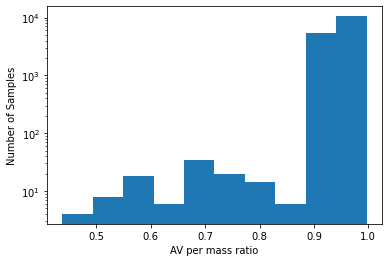

In [9]:
#plot distribution of AV per mass ratio
plt.hist(vmdata[vmdata.columns[21]][0:])
plt.yscale('log')
plt.xlabel('AV per mass ratio')
plt.ylabel('Number of Samples')
plt.show()


These graphs show the same trends as for void fraction ratio. The deviation from y=x is more clearly from the lower AV mass ratios in graphs such as diameter of the largest included sphere along free sphere path, ASA (m^s/cm^3), and ASA per mass. In the graphs, you can clearly see that the lower the value the greater the deviation from normal values. Additionally there is a correlation between unit cell volume and AV mass ratio. Lower values of unit cell volume correlate to the lower values for AV mass ratio.  

For the NAV and NASA graphs, the same trends as above apply but we see that it is not the dark green values closest to 1 that have the nonzero values but instead light green values that are still high but not the highest.

### Anomaly Detection Run on 5216 Structures with Lowest AV Mass Ratio

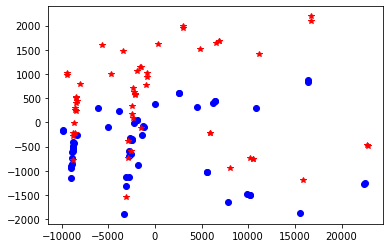

In [10]:
X = np.concatenate((vmdata[vmdata.columns[1:18]].values[right],vmdata[vmdata.columns[1:18]].values[wrong]), axis=0)
y = np.concatenate((vmdata[vmdata.columns[18]].values[right],vmdata[vmdata.columns[18]].values[wrong]), axis=0)
X1, y1 = pca_mle(X, y)

In [11]:
n = np.shape(X1)[1]
print(n)

13


In [12]:
def limit_y(X, y, per):
    count = 0
    norm = []
    anom = []
    for i in y:
        if i == 0:
            norm.append(count)
        else:
            anom.append(count)
        count += 1
    rp = np.array(np.random.permutation(np.size(anom)))
    anom = np.array(anom)
    norm = np.array(norm)
    num = int((per/(1-per)) * len(norm))
    newy = np.concatenate((y[norm], y[anom[rp[0:num]]]))
    newX = np.concatenate((X[norm, :], X[anom[rp[0:num]], :]))
    return newX, newy

In [13]:
X_, y_ = limit_y(X1, y1, .5)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state = 3)

In [15]:
def F1Calc(est_y, y):
    out = np.argwhere(y == -1)
    tp = sum(est_y[out] == y[out])
    anom = np.size(out);
    pos = sum((est_y == -1));
    rec = float(tp) / anom;
    try:
        prec = float(tp) / pos;
        F1 = (2 * prec * rec) / (prec + rec);
    except ZeroDivisionError:
        F1 = 0
    return F1


In [16]:
def print_stats(est_y, newy):
    compare = sum(est_y == newy)
    anom = np.argwhere(newy == -1);
    fanom = est_y[anom] == newy[anom];
    found = float(sum(fanom)) / np.size(anom) * 100;

    print('Accuracy:', float(compare) / np.size(newy) * 100)
    print('\nF1 Score:', F1Calc(est_y, newy))
    print('\nPercent Anomalies Found:', found)

In [17]:
newy_test = cy(y_test)
newy = cy(y_)

In [18]:
index = []
for j in range(np.shape(X_test)[0]):
    f = X_test[j,:]
    for i in range(np.shape(X1)[0]):
        if sum(X1[i,:] == f) == n:
            index.append(i)

In [19]:
dsfn=np.array(index)

In [20]:
def plotcorrect(est_ytest2, newy_test):
    c = 0
    right = []
    wrong = []
    for k in est_ytest2 == newy_test:
        if k == True:
            right.append(dsfn[c])
        else:
            wrong.append(dsfn[c])
        c += 1
        
    f = plt.figure()
    plt.scatter(vmdata[vmdata.columns[20]][right], vmdata[vmdata.columns[21]][right], c='b',label = 'Correct')
    plt.scatter(vmdata[vmdata.columns[20]][wrong], vmdata[vmdata.columns[21]][wrong], c='r',label = 'Wrong')
    plt.xlabel(vmdata.columns[20])
    plt.ylabel(vmdata.columns[21])
    plt.legend()
    plt.show()
    f.savefig('correct2.png', format='png', dpi = 1200)
    
    fig, axs = plt.subplots(1, 2, sharex=True, sharey = True)
    
    axs[0].hist(vmdata[vmdata.columns[21]][right],bins = 10)
    axs[1].hist(vmdata[vmdata.columns[21]][wrong], bins = 10)
    axs[0].set_xlabel('Correct')
    axs[1].set_xlabel('Wrong')
    plt.suptitle('AV per mass ratio')
    plt.show()

In [21]:
#outlier detecter
clf = LocalOutlierFactor(n_neighbors = 1)
est_y = clf.fit_predict(X_)
print_stats(est_y, newy)

Accuracy: 50.0

F1 Score: 0.22535211267605632

Percent Anomalies Found: 14.545454545454545


In [22]:
#novelty detection
nov = LocalOutlierFactor(n_neighbors = 8, novelty = True)
nov.fit(X_train)
est_ytest = nov.predict(X_test)
print_stats(est_ytest, newy_test)

Accuracy: 40.909090909090914

F1 Score: nan

Percent Anomalies Found: 0.0


<ipython-input-15-38002fa99a67>:9: RuntimeWarning: invalid value encountered in double_scalars
  F1 = (2 * prec * rec) / (prec + rec);


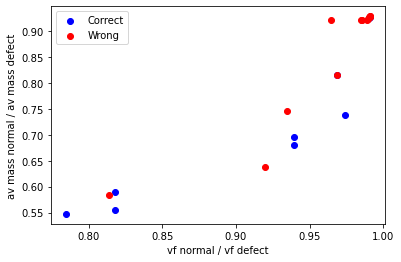

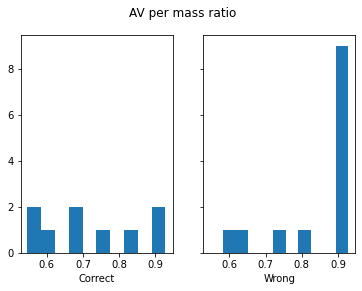

In [23]:
plotcorrect(est_ytest, newy_test)

In [24]:

#isolation forest
model = IsolationForest(n_estimators=50, max_samples=10,max_features=1)
model.fit(X_train)
est_ytest2 = model.predict(X_test)
print_stats(est_ytest2, newy_test)

Accuracy: 50.0

F1 Score: 0.4761904761904762

Percent Anomalies Found: 41.66666666666667


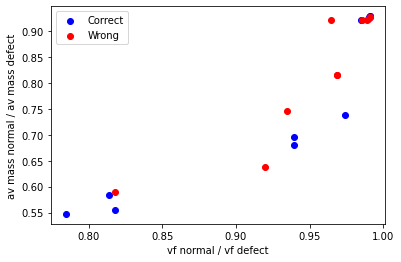

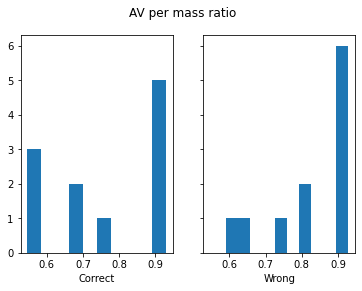

In [25]:
plotcorrect(est_ytest2, newy_test)

In [26]:
def calc_stats(acc, f1, p_anom, prec, est_y, ytest):
    compare = sum(est_y == ytest)
    anom = np.argwhere(ytest == -1);
    fanom = est_y[anom] == ytest[anom];
    anomm = np.argwhere(est_y == -1)
    found = float(sum(fanom)) / np.size(anom) * 100;
    try:
        precc = float(sum(fanom)) / np.size(anomm) * 100;
    except ZeroDivisionError:
        precc = 0
    

    acc[i] = float(compare) / np.size(ytest) * 100
    f1[i] = F1Calc(est_y, ytest)
    p_anom[i] = found
    prec[i] = precc
    return [acc, f1, p_anom, prec]
    

In [27]:
def plotvar(n_est, acc, p_anom, prec, f1, rtime, method, variable, showtime):
    f = plt.figure()
    name = method + variable + 'lowestrange.png'
    plt.plot(n_est, acc/100,label = 'Accuracy')
    plt.plot(n_est, p_anom/100,label = 'Percent Anomalies')
    plt.plot(n_est, prec/100, label = 'Precision')
    plt.plot(n_est, f1, label = 'F1')
    ind = np.argmax(f1)
    plt.plot(n_est[ind],f1[ind], '*', label = 'Highest F1 Score')
    plt.legend()
    plt.title(method)
    plt.xlabel(variable)
    plt.show()
    f.savefig(name, format = 'png', dpi = 1200)
    if showtime:
        plt.figure()
        plt.plot(n_est, rtime)
        plt.ylabel('Time (s)')
        plt.xlabel(variable)
        plt.title('Run Time')
        plt.show()

#### Optimizing Novelty Detection (n_neighbors)

In [42]:
m = 72
n_est3 = np.linspace(1, 72, m)
acc3 = np.zeros(m)
f13 = np.zeros(m)
p_anom3 = np.zeros(m)
time3 = np.zeros(m)
prec3 = np.zeros(m)
for i in range(m):
    start = timeit.default_timer()
    nov = LocalOutlierFactor(n_neighbors = int(n_est3[i]), novelty = True)
    nov.fit(X_train)
    est_ytest = nov.predict(X_test)
    stop = timeit.default_timer()
    
    [acc3, f13, p_anom3, prec3] = calc_stats(acc3, f13, p_anom3, prec3, est_ytest, newy_test)
    time3[i] = stop - start
   

<ipython-input-15-38002fa99a67>:9: RuntimeWarning: invalid value encountered in double_scalars
  F1 = (2 * prec * rec) / (prec + rec);
<ipython-input-15-38002fa99a67>:9: RuntimeWarning: invalid value encountered in double_scalars
  F1 = (2 * prec * rec) / (prec + rec);
<ipython-input-15-38002fa99a67>:9: RuntimeWarning: invalid value encountered in double_scalars
  F1 = (2 * prec * rec) / (prec + rec);
<ipython-input-15-38002fa99a67>:9: RuntimeWarning: invalid value encountered in double_scalars
  F1 = (2 * prec * rec) / (prec + rec);
<ipython-input-15-38002fa99a67>:9: RuntimeWarning: invalid value encountered in double_scalars
  F1 = (2 * prec * rec) / (prec + rec);
<ipython-input-15-38002fa99a67>:9: RuntimeWarning: invalid value encountered in double_scalars
  F1 = (2 * prec * rec) / (prec + rec);
<ipython-input-15-38002fa99a67>:9: RuntimeWarning: invalid value encountered in double_scalars
  F1 = (2 * prec * rec) / (prec + rec);
<ipython-input-15-38002fa99a67>:8: RuntimeWarning: inva

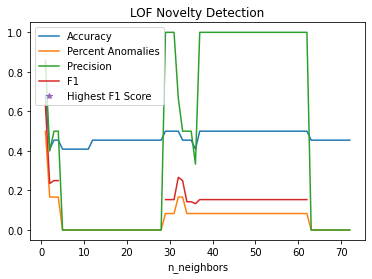

Highest F1 score recorded: 0.631578947368421 at 5.0 n_neighbor


In [43]:
plotvar(n_est3, acc3, p_anom3, prec3, f13, time3, 'LOF Novelty Detection', 'n_neighbors',0)
ind = np.argmax(f13)
print('Highest F1 score recorded:',max(f13), 'at', n_est3[ind], 'n_neighbor')

#### Optimizing Outlier Detection (n_neighbors)

In [40]:
m = 100
n_est2 = np.linspace(1, 72, m)
acc2 = np.zeros(m)
f12 = np.zeros(m)
p_anom2 = np.zeros(m)
time2 = np.zeros(m)
prec2 = np.zeros(m)
for i in range(m):
    start = timeit.default_timer()
    clf = LocalOutlierFactor(n_neighbors = int(n_est2[i]))
    est_y = clf.fit_predict(X_)
    stop = timeit.default_timer()
    
    [acc2, f12, p_anom2, prec2] = calc_stats(acc2, f12, p_anom2, prec2, est_y, newy)
    time2[i] = stop - start
    

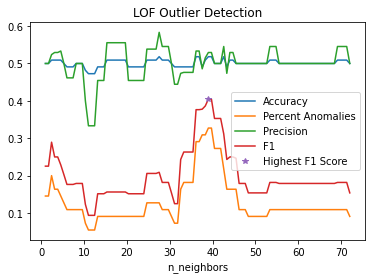

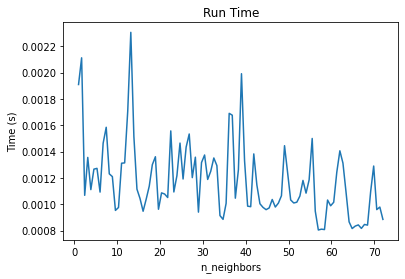

Highest F1 score recorded: 0.4044943820224719 at 39.01010101010101 n_neighbor
Highest F1 score recorded: 0.4044943820224719
Average F1 score: 0.20007943322675525
Standard Deviation: 0.0676568943860416


In [41]:
plotvar(n_est2, acc2, p_anom2, prec2, f12, time2, 'LOF Outlier Detection', 'n_neighbors',1)
ind = np.argmax(f12)
print('Highest F1 score recorded:',max(f12), 'at', n_est2[ind], 'n_neighbor')
print('Highest F1 score recorded:',f12[ind])
print('Average F1 score:',np.mean(f12))
print('Standard Deviation:',np.std(f12))

#### Optimizing Isolation Forest (n_estimators)

In [32]:
m = 100
n_est1 = np.linspace(10, 4000, m)
acc1 = np.zeros(m)
f11 = np.zeros(m)
p_anom1 = np.zeros(m)
rtime1 = np.zeros(m)
prec1 = np.zeros(m)
for i in range(m):
    start = timeit.default_timer()
    model = IsolationForest(n_estimators = int(n_est1[i]), max_samples=10,max_features=6)
    model.fit(X_train)
    est_ytest2 = model.predict(X_test)
    stop = timeit.default_timer()
    
    [acc1, f11, p_anom1, prec1] = calc_stats(acc1, f11, p_anom1, prec1, est_ytest2, newy_test)
    rtime1[i] = stop - start

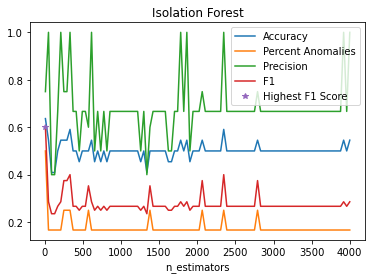

Highest F1 score recorded: 0.6 at 10.0 n_estimators


In [33]:
plotvar(n_est1, acc1, p_anom1, prec1, f11, rtime1, 'Isolation Forest', 'n_estimators',0)
ind = np.argmax(f11)
print('Highest F1 score recorded:',f11[ind], 'at', n_est1[ind], 'n_estimators')


#### Optimizing Isolation Forest (max_samples)

In [34]:
m = 85
n_est_ = np.linspace(5, 89, m)
acc_ = np.zeros(m)
f1_ = np.zeros(m)
p_anom_ = np.zeros(m)
rtime_ = np.zeros(m)
prec_ = np.zeros(m)
for i in range(m):
    start = timeit.default_timer()
    model = IsolationForest(n_estimators = 10, max_samples=int(n_est_[i]),max_features=6)
    model.fit(X_train)
    est_ytest2 = model.predict(X_test)
    stop = timeit.default_timer()
    
    [acc_, f1_, p_anom_, prec_] = calc_stats(acc_, f1_, p_anom_, prec_, est_ytest2, newy_test)
    rtime_[i] = stop - start

/Users/christinatan/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_iforest.py:289: UserWarning: max_samples (89) is greater than the total number of samples (88). max_samples will be set to n_samples for estimation.
  warn(


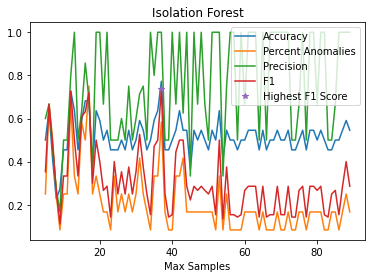

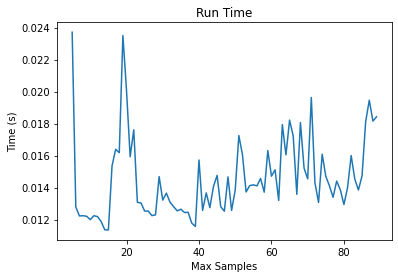

Highest F1 score recorded: 0.7368421052631579 at 37.0 max_samples


In [35]:
plotvar(n_est_, acc_, p_anom_, prec_, f1_, rtime_, 'Isolation Forest', 'Max Samples',1)
ind = np.argmax(f1_)
print('Highest F1 score recorded:',f1_[ind], 'at', n_est_[ind], 'max_samples')

In [36]:
#isolation forest
model = IsolationForest(n_estimators=375, max_samples=12,max_features=6)
model.fit(X_train)
est_ytest2_ = model.predict(X_test)
print_stats(est_ytest2_, newy_test)

Accuracy: 54.54545454545454

F1 Score: 0.2857142857142857

Percent Anomalies Found: 16.666666666666664


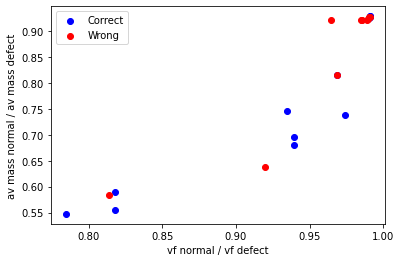

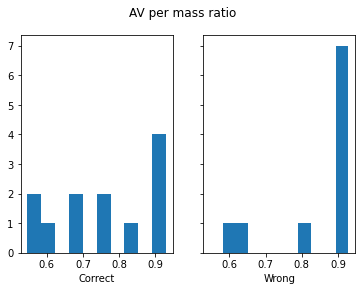

In [37]:
plotcorrect(est_ytest2_, newy_test)

In [38]:
m = 100
acc1 = np.zeros(m)
f11 = np.zeros(m)
p_anom1 = np.zeros(m)
rtime1 = np.zeros(m)
prec1 = np.zeros(m)
for i in range(m):
    start = timeit.default_timer()
    model = IsolationForest(n_estimators = 375, max_samples=12,max_features=6)
    model.fit(X_train)
    est_ytest2 = model.predict(X_test)
    stop = timeit.default_timer()
    
    [acc1, f11, p_anom1, prec1] = calc_stats(acc1, f11, p_anom1, prec1, est_ytest2, newy_test)
    rtime1[i] = stop - start

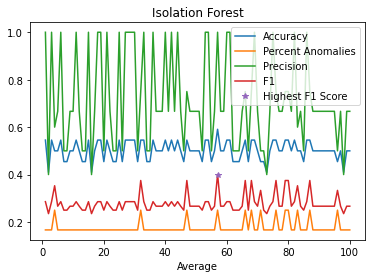

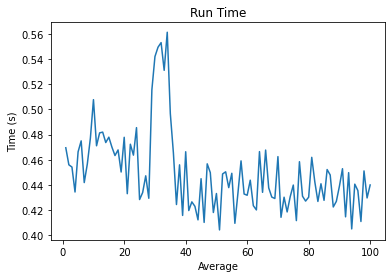

Highest F1 score recorded: 0.4
Average F1 score: 0.28008963585434166
Standard Deviation: 0.036925619414914644


In [39]:
n_est1 = np.linspace(1, 100, m)
plotvar(n_est1, acc1, p_anom1, prec1, f11, rtime1, 'Isolation Forest', 'Average',1)
ind = np.argmax(f11)
print('Highest F1 score recorded:',f11[ind])
print('Average F1 score:',np.mean(f11))
print('Standard Deviation:',np.std(f11))